In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets
from torchvision.utils import make_grid
device = torch.device("mps")
import warnings
warnings.filterwarnings('ignore')
from torchinfo import summary

In [2]:
#load dataset
#apply to Tensor transform in dataset
transform = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='/Users/aadityajoshi/Downloads/KD',transform=transform,train=True,download=True)
test_ds = datasets.FashionMNIST(root='/Users/aadityajoshi/Downloads/KD',transform=transform,train=False,download=True)

In [3]:
#size of image
train_ds[0][0].shape

torch.Size([1, 28, 28])

In [41]:
#loader
train_loader = DataLoader(train_ds,batch_size=32,shuffle=False)
test_loader = DataLoader(test_ds,batch_size=32,shuffle=False)

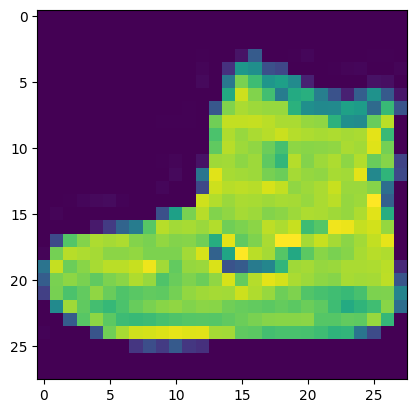

In [5]:
#visualize
plt.imshow(train_ds[0][0].numpy().reshape(28,28))

### Func for dimension calc

In [6]:
def dim_calc(n_in,w_in,h_in,f,s,p,num_filters,max_pool,ms,mf):
    """Input : In_channels, Width_in, Height_in, Filter_size, Maxpool (Bool) , Maxpool stride and Filter size
    Output :Dimensions After Conv layer """
    #(height,widht)
    
    if type(s) == tuple: #(2,1)
        s_h = s[0]
        s_w = s[1]
    else:
        s_h,s_w = s,s
    if type(f) == tuple:
        f_h = f[0]
        f_w = f[1]
    else:
        f_h,f_w = f,f
    if type(p) == tuple:
        p_h = p[0]
        p_w = p[1]
    else:
        p_h,p_w = p,p
        
    height = ((h_in-f_h+2*p_h)//s_h)+1
    width = ((w_in-f_w+2*p_w)//s_w)+1
    channels = num_filters
    if max_pool == True:
        height = ((height-mf)//ms)+1
        width = ((width-mf)//ms)+1
    return (channels,height,width)

### create models

### LeNet insp model

In [7]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        #conv1 6 filters
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
        #conv2 16 filters
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
        #first fully connected layer
        self.fc1 = nn.Linear(in_features=400,out_features=128)
        #second fully connected layer
        self.fc2 = nn.Linear(in_features=128,out_features=32)
        #third fully connected layer
        self.fc3 = nn.Linear(in_features=32,out_features=10)
    def forward(self,x):
        #activation function + conv
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [8]:
print(f"1 : {dim_calc(1,28,28,3,1,0,6,True,2,2)}")
print(f"2 : {dim_calc(6,13,13,3,1,0,16,True,2,2)}")
print(16*5*5)

1 : (6, 13, 13)
2 : (16, 5, 5)
400


### reduced model precision for lesser memory usage

In [9]:
lenet = Lenet().to(torch.bfloat16).to(device)

In [10]:
lenet

Lenet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [11]:
params = [p.numel() for p in lenet.parameters() if p.requires_grad]
for p in params:
    print(p)
print(f"Total Parameters : {sum(params)}")

54
6
864
16
51200
128
4096
32
320
10
Total Parameters : 56726


### training

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(),lr=0.001)
num_epochs = 10

In [13]:
import time
from tqdm import tqdm
start = time.time()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    lenet.train()
    for data,label in pbar:
        data,label = data.to(torch.bfloat16).to(device),label.to(device)
        y_pred = lenet.forward(data)
        loss = criterion(y_pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10: 100%|█████████████| 1875/1875 [00:09<00:00, 201.51it/s, loss=0.4629]


Epoch 1/10, Average Loss: 0.6710


Epoch 2/10: 100%|█████████████| 1875/1875 [00:08<00:00, 208.55it/s, loss=0.2793]


Epoch 2/10, Average Loss: 0.4992


Epoch 3/10: 100%|█████████████| 1875/1875 [00:09<00:00, 208.29it/s, loss=0.4414]


Epoch 3/10, Average Loss: 0.4571


Epoch 4/10: 100%|█████████████| 1875/1875 [00:08<00:00, 208.67it/s, loss=0.3008]


Epoch 4/10, Average Loss: 0.4347


Epoch 5/10: 100%|█████████████| 1875/1875 [00:09<00:00, 208.25it/s, loss=0.3047]


Epoch 5/10, Average Loss: 0.4204


Epoch 6/10: 100%|█████████████| 1875/1875 [00:09<00:00, 195.50it/s, loss=0.2969]


Epoch 6/10, Average Loss: 0.4073


Epoch 7/10: 100%|█████████████| 1875/1875 [00:09<00:00, 207.14it/s, loss=0.2188]


Epoch 7/10, Average Loss: 0.4014


Epoch 8/10: 100%|█████████████| 1875/1875 [00:08<00:00, 221.62it/s, loss=0.4414]


Epoch 8/10, Average Loss: 0.3953


Epoch 9/10: 100%|█████████████| 1875/1875 [00:08<00:00, 217.04it/s, loss=0.3887]


Epoch 9/10, Average Loss: 0.3888


Epoch 10/10: 100%|████████████| 1875/1875 [00:10<00:00, 185.49it/s, loss=0.3984]

Epoch 10/10, Average Loss: 0.3851
Total training time: 1.52 minutes


In [14]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []
  
lenet.eval()
with torch.no_grad():
    for data, label in test_loader:
        data,label = data.to(torch.bfloat16).to(device),label.to(device)
        pred = lenet(data)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1000
           1       0.99      0.95      0.97      1000
           2       0.73      0.81      0.77      1000
           3       0.85      0.89      0.86      1000
           4       0.73      0.78      0.76      1000
           5       0.96      0.95      0.95      1000
           6       0.67      0.47      0.55      1000
           7       0.91      0.94      0.93      1000
           8       0.94      0.96      0.95      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [15]:
x = torch.randint(low=0,high=10,size=(10,1),dtype=torch.float32)

In [16]:
x

tensor([[3.],
        [3.],
        [2.],
        [9.],
        [2.],
        [6.],
        [6.],
        [6.],
        [9.],
        [7.]])

In [17]:
#temp
x_s = F.log_softmax(x,dim=0)
x_s_2 = F.log_softmax(x/2,dim=0)
x_s_3 = F.log_softmax(x/3,dim=0)
x_s_4 = F.log_softmax(x/4,dim=0)

In [18]:
x_s.std()

tensor(2.6687)

In [19]:
x_s_2.std()

tensor(1.3344)

In [20]:
x_s_3.std()

tensor(0.8896)

In [21]:
x_s_4.std()

tensor(0.6672)

In [22]:
x_s

tensor([[-6.8292],
        [-6.8292],
        [-7.8292],
        [-0.8292],
        [-7.8292],
        [-3.8292],
        [-3.8292],
        [-3.8292],
        [-0.8292],
        [-2.8292]])

In [23]:
#values are less sharp with 
x_s_4

tensor([[-3.0722],
        [-3.0722],
        [-3.3222],
        [-1.5722],
        [-3.3222],
        [-2.3222],
        [-2.3222],
        [-2.3222],
        [-1.5722],
        [-2.0722]])

### VGG based model

In [24]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(in_features=576,out_features=288)
        self.fc2 = nn.Linear(in_features=288,out_features=144)
        self.fc3 = nn.Linear(in_features=144,out_features=72)
        self.fc4 = nn.Linear(in_features=72,out_features=36)
        self.out = nn.Linear(in_features=36,out_features=10)
    def forward(self,x):
        #activation function + conv
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,576)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [25]:
print(f"1 : {dim_calc(1,28,28,3,1,(2,2),8,True,2,2)}")
print(f"2 : {dim_calc(8,13,13,3,1,(2,2),16,True,2,2)}")
print(f"3 : {dim_calc(16,5,5,3,1,(2,2),32,True,2,2)}")
print(64*3*3)

1 : (8, 15, 15)
2 : (16, 7, 7)
3 : (32, 3, 3)
576


In [26]:
vgg = VGG().to(device)

In [27]:
vgg

VGG(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=576, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=144, bias=True)
  (fc3): Linear(in_features=144, out_features=72, bias=True)
  (fc4): Linear(in_features=72, out_features=36, bias=True)
  (out): Linear(in_features=36, out_features=10, bias=True)
)

In [28]:
params = [p.numel() for p in vgg.parameters() if p.requires_grad]
for p in params:
    print(p)
print(f"Total Parameters : {sum(params)}")

144
16
4608
32
18432
64
165888
288
41472
144
10368
72
2592
36
360
10
Total Parameters : 244526


In [29]:
summary(vgg)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Linear: 1-4                            166,176
├─Linear: 1-5                            41,616
├─Linear: 1-6                            10,440
├─Linear: 1-7                            2,628
├─Linear: 1-8                            370
Total params: 244,526
Trainable params: 244,526
Non-trainable params: 0

In [30]:
import torch

def get_model_size(model, dtype=torch.bfloat16):
    total_params = sum(p.numel() for p in model.parameters())  
    total_buffers = sum(b.numel() for b in model.buffers())  
    total_elements = total_params + total_buffers  
    dtype_size = torch.finfo(dtype).bits // 8  # Get dtype size in bytes
    memory_size = total_elements * dtype_size  
    return memory_size / (1024 ** 2)  # Convert to MB

# Example usage with a sample model
print(f"Lenet size: {get_model_size(lenet, torch.bfloat16):.4f} MB")
print(f"Vgg size: {get_model_size(vgg, torch.float32):.4f} MB")

Lenet size: 0.1082 MB
Vgg size: 0.9328 MB


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(),lr=0.001)
num_epochs = 10

In [32]:
start = time.time()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    vgg.train()
    for data,label in pbar:
        data,label = data.to(device),label.to(device)
        y_pred = vgg.forward(data)
        loss = criterion(y_pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10: 100%|█████████████| 1875/1875 [00:13<00:00, 136.05it/s, loss=0.2291]


Epoch 1/10, Average Loss: 0.6312


Epoch 2/10: 100%|█████████████| 1875/1875 [00:12<00:00, 154.30it/s, loss=0.1785]


Epoch 2/10, Average Loss: 0.3652


Epoch 3/10: 100%|█████████████| 1875/1875 [00:11<00:00, 168.08it/s, loss=0.4567]


Epoch 3/10, Average Loss: 0.3031


Epoch 4/10: 100%|█████████████| 1875/1875 [00:11<00:00, 167.95it/s, loss=0.2926]


Epoch 4/10, Average Loss: 0.2679


Epoch 5/10: 100%|█████████████| 1875/1875 [00:11<00:00, 168.96it/s, loss=0.1598]


Epoch 5/10, Average Loss: 0.2405


Epoch 6/10: 100%|█████████████| 1875/1875 [00:10<00:00, 174.12it/s, loss=0.1418]


Epoch 6/10, Average Loss: 0.2207


Epoch 7/10: 100%|█████████████| 1875/1875 [00:11<00:00, 162.17it/s, loss=0.4373]


Epoch 7/10, Average Loss: 0.2024


Epoch 8/10: 100%|█████████████| 1875/1875 [00:13<00:00, 140.33it/s, loss=0.1608]


Epoch 8/10, Average Loss: 0.1874


Epoch 9/10: 100%|█████████████| 1875/1875 [00:12<00:00, 148.17it/s, loss=0.2569]


Epoch 9/10, Average Loss: 0.1738


Epoch 10/10: 100%|████████████| 1875/1875 [00:12<00:00, 151.77it/s, loss=0.1021]

Epoch 10/10, Average Loss: 0.1584
Total training time: 2.00 minutes


In [33]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []
  
vgg.eval()
with torch.no_grad():
    for data, label in test_loader:
        data,label = data.to(device),label.to(device)
        pred = vgg(data)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.83      0.91      0.87      1000
           3       0.93      0.88      0.90      1000
           4       0.82      0.90      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.73      0.75      1000
           7       0.97      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### creating label for  student model

In [42]:
label_list = []
for x,y in train_loader:
    x,y = x.to(device),y.to(device)
    y_pred = vgg.forward(x)
    label_list.append(y_pred)

In [44]:
import time
from tqdm import tqdm
start = time.time()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    lenet.train()
    i = 0 
    for data,label in pbar:
        i = i + 1
        data,label = data.to(torch.bfloat16).to(device),label.to(device)
        y_pred = lenet.forward(data)
        loss = criterion(y_pred,label_list[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10:   0%|             | 1/1875 [00:00<11:24,  2.74it/s, loss=-1769.8129]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [MPSFloatType [10, 36]] is at version 18752; expected version 18751 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).